In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from src.simulate_ctmc import simulate_protocol  # Use your actual MUFASA function

# Define laser powers
laser_powers = np.linspace(0.1, 10, 200)

# Molecule parameters (EGFP in FF protocol)
molecule = {
    "epsilon": 239000,
    "excitation_lifetime": 1e-9,
    "num_cycles_before_bleaching": 7000,
    "alpha_nr": 1,
    "d_E": 0.5,
    "alpha_isc": 1e-3
}

# Base experimental setup (will be copied for each power)
base_experiment_setup = {
    "protocol": "FF",
    "num_frames": 500,
    "frame_length": 0.01,
    "activation_rate": 1e-6,
    "excitation_wavelength": 488
}

# Simulate one power level: returns (mean_emission, mean_bleach_frame, traces, all_bleach_frames)
def simulate_power(P):
    experiment_setup = base_experiment_setup.copy()
    experiment_setup["excitation_P"] = P
    experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

    all_photons = []
    bleach_frames = []
    example_traces = []

    for i in range(10):  # simulate 10 molecules
        times, dynamics, Q, photons = simulate_protocol(experiment_setup, molecule, seed=42 + i)
        all_photons.append(photons)

        # Save 3 traces per power
        if len(example_traces) < 3:
            frame_times = np.arange(experiment_setup["num_frames"]) * experiment_setup["frame_length"]
            example_traces.append((frame_times, photons))

        # Compute bleaching frame
        try:
            bleaching_state = Q.shape[0] - 1  # last state is "B"
            if bleaching_state in dynamics:
                bleach_time = times[np.argmax(dynamics == bleaching_state)]
                bleach_frame = int(bleach_time // experiment_setup["frame_length"])
                bleach_frame = min(bleach_frame, experiment_setup["num_frames"])
            else:
                bleach_frame = experiment_setup["num_frames"]
        except:
            bleach_frame = experiment_setup["num_frames"]

        bleach_frames.append(bleach_frame)

    all_photons = np.array(all_photons)
    mean_emission = all_photons.sum(axis=1).mean()
    mean_bleach_frame = np.mean(bleach_frames)

    return mean_emission, mean_bleach_frame, example_traces, bleach_frames

# Run simulation in parallel over all powers
results = Parallel(n_jobs=-1, backend="loky")(delayed(simulate_power)(P) for P in laser_powers)

# Unpack results
mean_photon_emission = []
bleaching_onset_frames = []
example_dynamics_per_power = []
all_bleaching_frames = []

for r in results:
    mean_photon_emission.append(r[0])
    bleaching_onset_frames.append(r[1])
    example_dynamics_per_power.append(r[2])
    all_bleaching_frames.append(r[3])  # list of 10 bleach frames




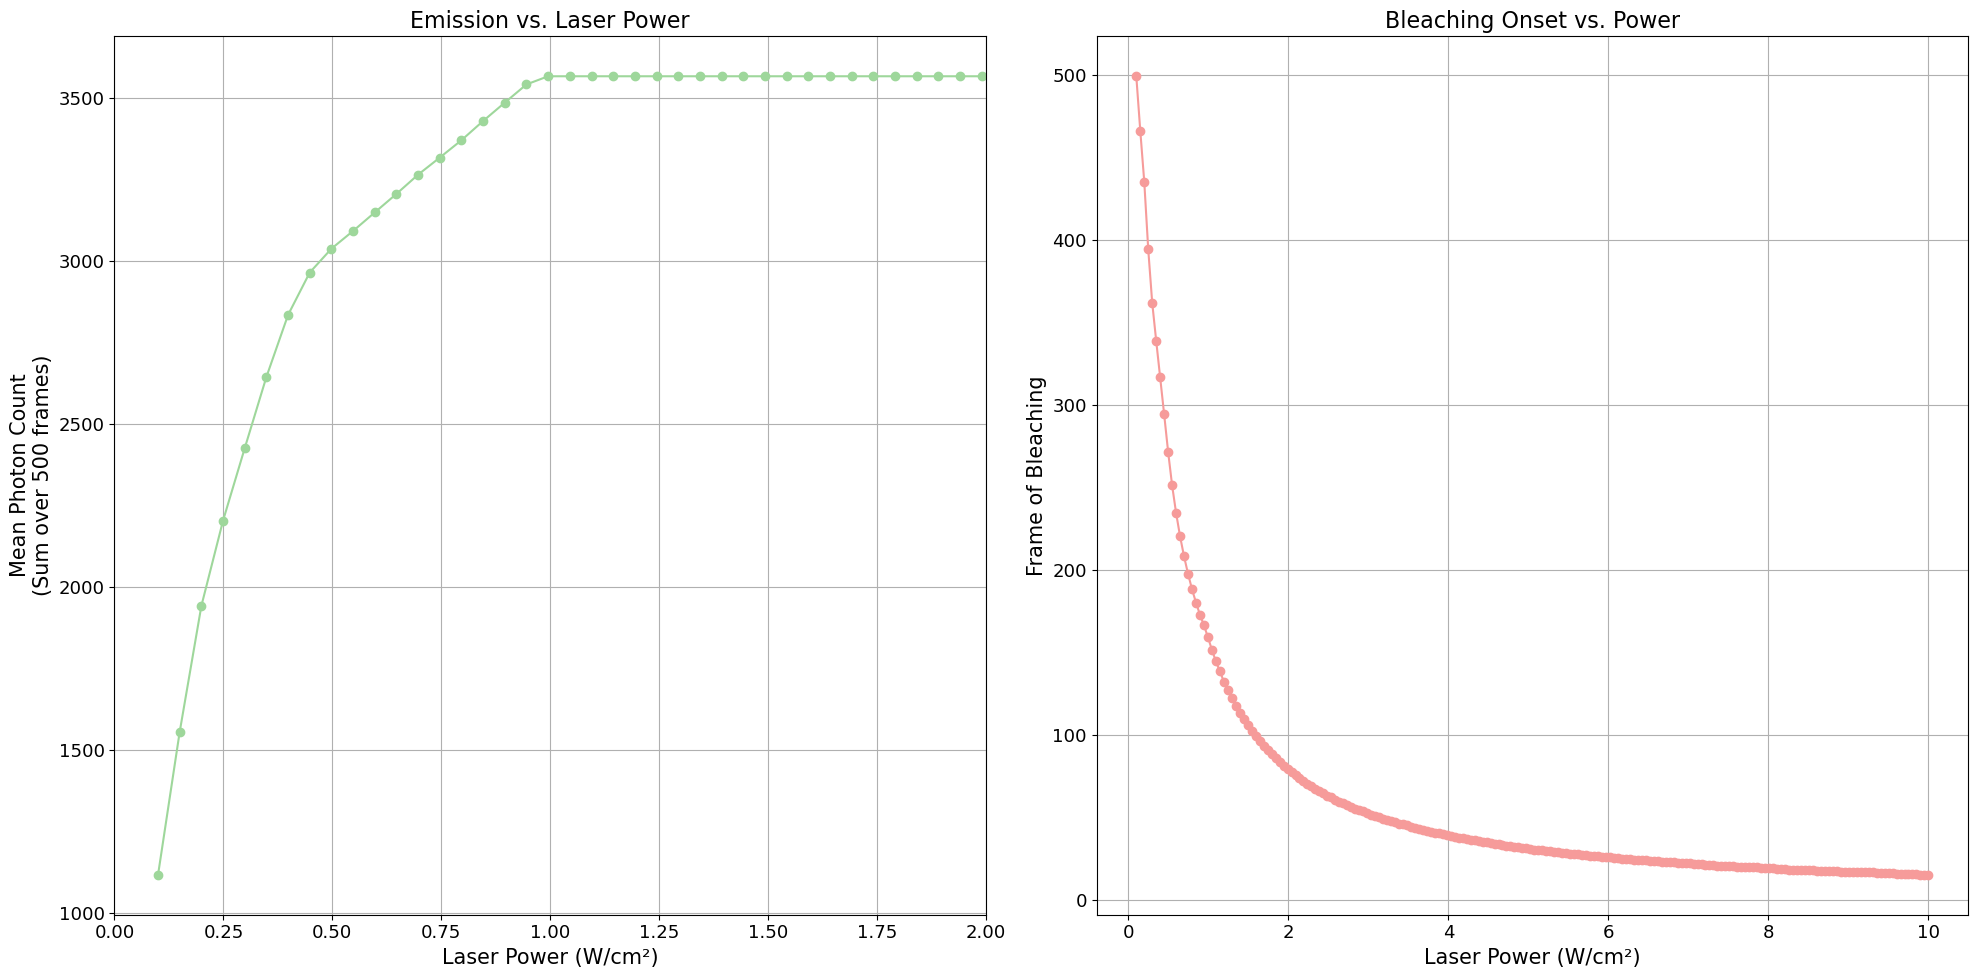

In [4]:
# --------------------------------------
# Plot summary: mean emission and bleaching frame vs. power
# --------------------------------------
# Global font settings for clarity in publication
plt.rcParams.update({
    'font.size': 14,        # Base font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 15,   # Axis label size
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13
})

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(laser_powers, mean_photon_emission, '-o', color='#9ed79b')
axes[0].set_xlabel("Laser Power (W/cm²)")
axes[0].set_ylabel("Mean Photon Count\n(Sum over 500 frames)")
axes[0].set_title("Emission vs. Laser Power")
axes[0].grid(True)
axes[0].set_xlim(0, 2)

axes[1].plot(laser_powers, bleaching_onset_frames, '-o', color='#f69b9a')
axes[1].set_xlabel("Laser Power (W/cm²)")
axes[1].set_ylabel("Frame of Bleaching")
axes[1].set_title("Bleaching Onset vs. Power")
axes[1].grid(True)

plt.tight_layout()
plt.savefig("bleaching_emission_vs_power.svg", format="svg")
plt.show()

# # --------------------------------------
# # Plot traces for all powers and print bleaching info
# # --------------------------------------
# for i, P in enumerate(laser_powers):
#     print(f"\nLaser Power = {P:.2f} W/cm²")
#     print("Bleaching frames (out of 500):", all_bleaching_frames[i])

#     fig, ax = plt.subplots(figsize=(6, 3))
#     for times, photons in example_dynamics_per_power[i]:
#         ax.plot(times, photons, alpha=0.7)
#     ax.set_title(f"Photon Traces at {P:.2f} W/cm²", fontsize=12)
#     ax.set_xlabel("Time (s)")
#     ax.set_ylabel("Photons per Frame")
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()